# Customer Lifetime Value

In [1]:
import pandas as pd
import json

df = pd.read_json('raw_customer_data.json', lines=True, orient='records') # read the document store to dataframe
df = df.explode("transactions") # because trasnsactions is a list of dicts
id = df["id"].reset_index() # keep the ids 
df = pd.json_normalize(df["transactions"]) # dict to dataframe

data = pd.merge(id,df,left_index=True, right_index=True)

data

,index,id,settledAt,ftd,amount,status,type
0,0,128867,2022-03-10T14:14:34.583+0000,True,40.0,SUCCESS,deposit
1,1,128853,2022-03-10T11:30:45.292+0000,False,50.0,SUCCESS,deposit
2,1,128853,2022-03-10T09:55:57.469+0000,1.0,50.0,SUCCESS,deposit
3,2,128850,2022-03-10T11:06:32.510+0000,True,159.0,SUCCESS,deposit
4,2,128850,2022-03-10T11:32:38.318+0000,0.0,180.0,FAIL,deposit
...,...,...,...,...,...,...,...
180746,6675,5825,2020-03-23T08:26:33.212+0000,0.0,20.0,CANCEL,deposit
180747,6675,5825,2020-03-20T13:38:59.789+0000,0.0,25.0,FAIL,deposit
180748,6676,5774,2019-12-15T20:09:26.286+0000,False,50.0,ERROR,withdrawal
180749,6676,5774,2019-12-16T06:49:49.786+0000,0.0,50.0,SUCCESS,withdrawal


# EDA

In [2]:
#Get overview of the data
def dataoveriew(df):
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

dataoveriew(data)

Number of rows:  180751

Number of features: 7

Data Features:
['index', 'id', 'settledAt', 'ftd', 'amount', 'status', 'type']

Missing values: 0

Unique values:
index          6677
id             6661
settledAt    180663
ftd               2
amount         9400
status            5
type              3
dtype: int64


In [3]:
data.dtypes

index          int64
id             int64
settledAt     object
ftd           object
amount       float64
status        object
type          object
dtype: object

In [4]:
data.groupby('status')['id'].count()

status
CANCEL      20662
ERROR        6621
FAIL        27021
INITIAL         7
SUCCESS    126440
Name: id, dtype: int64

In [5]:
data.groupby('type')['id'].count()

type
deposit       92958
transfer       6583
withdrawal    81210
Name: id, dtype: int64

In [6]:
# some ids have more than one 1.0 ftd count. it cannot be true.

data['ftd'] = data['ftd'].astype(float) # convert to float to be able to count 
data.groupby('id')['ftd'].value_counts().to_frame()

ftd
id     ftd     
5774   0.0    2
       1.0    1
5825   0.0    8
       1.0    1
5830   0.0    2
...         ...
128850 0.0    2
       1.0    2
128853 0.0    2
       1.0    2
128867 1.0    2

[12985 rows x 1 columns]

In [7]:
data[data['id']== 128785] # there are dublicate lines 9 and 140899

,index,id,settledAt,ftd,amount,status,type
9,5,128785,2022-03-14T09:25:37.516+0000,1.0,40.0,SUCCESS,deposit
10,5,128785,2022-03-14T09:12:39.813+0000,0.0,40.0,INITIAL,deposit
140899,5593,128785,2022-03-14T09:25:37.516+0000,1.0,40.0,SUCCESS,deposit
140900,5593,128785,2022-03-14T10:27:07.348+0000,0.0,40.0,FAIL,deposit


In [8]:
data = data.drop(['index'],axis=1)

data = data.drop_duplicates(ignore_index = True)   # remove dubplicates

# disregard all transactions that took place before the date of the ftd

import datetime

ids = list(data['id'].unique())

for id in ids:
    first_date = data[data['id'] == id][data['ftd']==1.0]['settledAt']
    first_date = pd.to_datetime(first_date.values)
    for k in (data[data['id'] == id][data['ftd']==0.0]['settledAt']).values :
        if k < first_date:
            i = data[data['id'] == id][data['settledAt'] == k].index
            data = data.drop(i)

In [10]:
data

,id,settledAt,ftd,amount,status,type
0,128867,2022-03-10T14:14:34.583+0000,1.0,40.0,SUCCESS,deposit
1,128853,2022-03-10T11:30:45.292+0000,0.0,50.0,SUCCESS,deposit
2,128853,2022-03-10T09:55:57.469+0000,1.0,50.0,SUCCESS,deposit
3,128850,2022-03-10T11:06:32.510+0000,1.0,159.0,SUCCESS,deposit
4,128850,2022-03-10T11:32:38.318+0000,0.0,180.0,FAIL,deposit
...,...,...,...,...,...,...
180654,5825,2020-03-23T08:48:32.463+0000,1.0,20.0,SUCCESS,deposit
180656,5825,2020-03-23T09:31:08.219+0000,0.0,20.0,FAIL,deposit
180661,5774,2019-12-15T20:09:26.286+0000,0.0,50.0,ERROR,withdrawal
180662,5774,2019-12-16T06:49:49.786+0000,0.0,50.0,SUCCESS,withdrawal


In [11]:
data.groupby('status')['id'].count() # almost none of the dropped lines had status as success 

status
CANCEL      14898
ERROR        6558
FAIL        24087
INITIAL         6
SUCCESS    126391
Name: id, dtype: int64

In [12]:
data.groupby('type')['id'].count() # almost all dropped lines where a deposit type

type
deposit       84182
transfer       6576
withdrawal    81182
Name: id, dtype: int64

In [13]:
# Next, let's do some visualisations 

timeseries = data.sort_values(by='settledAt') # sort data by date 
timeseries['settledAt'] = pd.to_datetime(timeseries['settledAt'])
timeseries = timeseries.set_index('settledAt') # set index = date

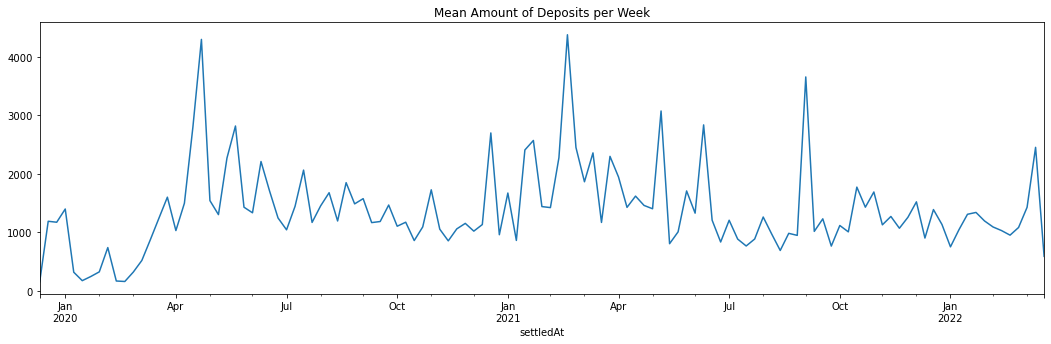

In [14]:
import matplotlib.pyplot as plt

# Mean Amount of Deposits per Week

ts_deposit = timeseries[timeseries['type']=='deposit']

# Per week resample and take the mean
plt.subplots(figsize=(18, 5))
plt.title('Mean Amount of Deposits per Week')
ax =ts_deposit.resample("W")['amount'].mean().plot(kind="line")

<AxesSubplot:title={'center':'Mean Amount of Deposits per 10-days rolling window'}, xlabel='settledAt'>

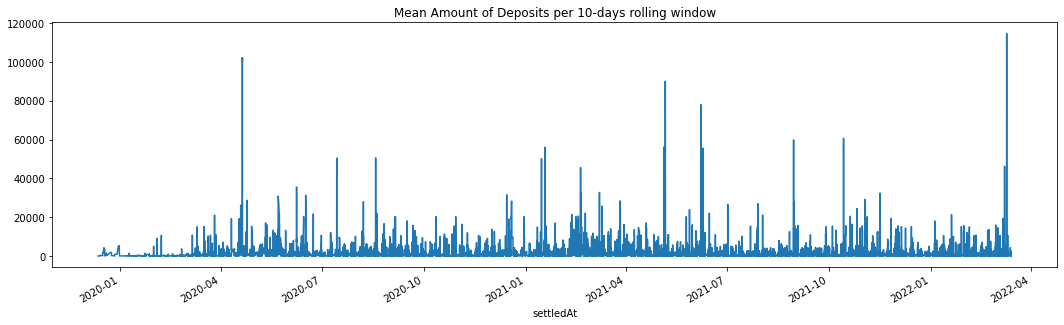

In [15]:
# Mean Amount of Deposits per 10-days rolling window

rw = ts_deposit['amount'].rolling(window=10)
plt.subplots(figsize=(18, 5))
plt.title('Mean Amount of Deposits per 10-days rolling window')
rw.mean().plot()

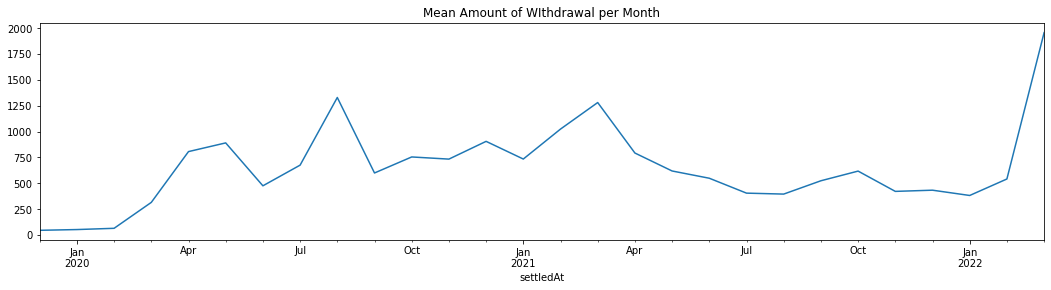

In [16]:
#  Mean Amount of WIthdrawal per Month

ts_withdrawal = timeseries[timeseries['type']=='withdrawal']
plt.subplots(figsize=(18, 4))
plt.title('Mean Amount of WIthdrawal per Month')
ax =ts_withdrawal.resample("M")['amount'].mean().plot(kind="line")

# more withdrawals during covid 19 period

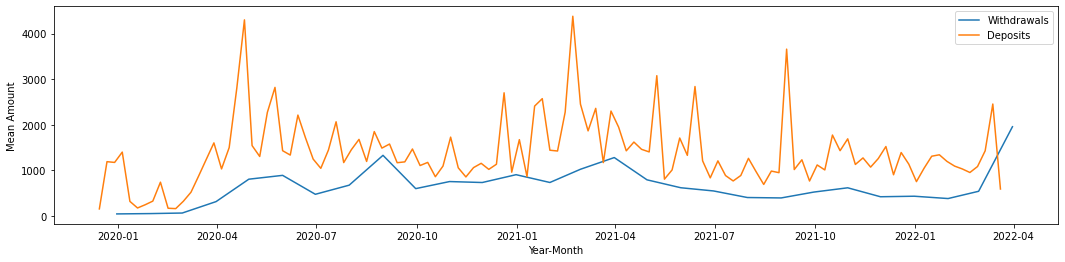

In [19]:
plt.subplots(figsize=(18, 4))
plt.plot (ts_withdrawal.resample("M")['amount'].mean(), label='Withdrawals')
plt.plot(ts_deposit.resample("W")['amount'].mean(), label = 'Deposits')
plt.xlabel('Year-Month')
plt.ylabel('Mean Amount')
plt.legend() 
plt.show()

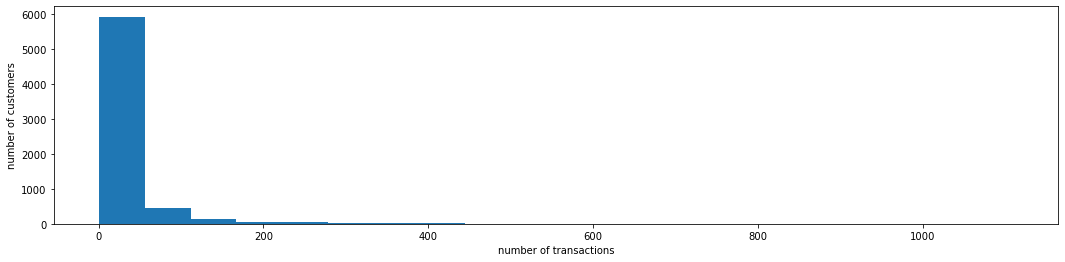

Total number of customers:   6661


In [37]:
transactions_count = data.groupby('id').count()['settledAt'].sort_values(ascending=False)
fig,ax = plt.subplots(figsize=(18, 4))
ax.hist(transactions_count,bins =20)
plt.xlabel('number of transactions')
plt.ylabel('number of customers')
plt.show()

print('Total number of customers:   6661')

From the histogram above we see that almost all of our customers have less than 150 transactions in total for the 28-months period.

# CLV model

In [271]:
# new column of month and year of the transaction

data['settledAt'] = pd.to_datetime(data['settledAt'])
data['month_yr'] = data['settledAt'].apply(lambda x: x.strftime('%b-%Y'))

# drop lines with unsuccessfull transactions so as not to count their amount on the model
data = data.drop(data[data['status']=='FAIL'].index)
data = data.drop(data[data['status']=='CANCEL'].index)
data = data.drop(data[data['status']=='ERROR'].index)

data = data.drop(data[data['amount']==0.0].index) # drop lines with zero value
data = data.reset_index(drop=True)
data

,id,settledAt,ftd,amount,status,type,month_yr
0,128867,2022-03-10 14:14:34.583000+00:00,1.0,40.0,SUCCESS,deposit,Mar-2022
1,128853,2022-03-10 11:30:45.292000+00:00,0.0,50.0,SUCCESS,deposit,Mar-2022
2,128853,2022-03-10 09:55:57.469000+00:00,1.0,50.0,SUCCESS,deposit,Mar-2022
3,128850,2022-03-10 11:06:32.510000+00:00,1.0,159.0,SUCCESS,deposit,Mar-2022
4,128797,2022-03-10 08:40:27.015000+00:00,1.0,100.0,SUCCESS,deposit,Mar-2022
...,...,...,...,...,...,...,...
126389,5825,2020-03-26 09:52:46.377000+00:00,0.0,20.0,SUCCESS,deposit,Mar-2020
126390,5825,2020-03-23 13:15:44.117000+00:00,0.0,6.0,SUCCESS,withdrawal,Mar-2020
126391,5825,2020-03-23 08:48:32.463000+00:00,1.0,20.0,SUCCESS,deposit,Mar-2020
126392,5774,2019-12-16 06:49:49.786000+00:00,0.0,50.0,SUCCESS,withdrawal,Dec-2019


In [272]:
# create a pivot table of the sum of transactions per month for each customer.

transactions = data.pivot_table(index=['id'],columns=['month_yr'],values='amount',
                                aggfunc='sum',fill_value=0).reset_index()

# add a column with the sum of all months for each customer which is equal to the CLV 

transactions['CLV'] = transactions.iloc[:,1:].sum(axis=1)

transactions.head(5)

month_yr,id,Apr-2020,Apr-2021,Aug-2020,Aug-2021,Dec-2019,Dec-2020,Dec-2021,Feb-2020,Feb-2021,...,Mar-2022,May-2020,May-2021,Nov-2020,Nov-2021,Oct-2020,Oct-2021,Sep-2020,Sep-2021,CLV
0,5774,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00
1,5825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.00
2,5830,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00
3,5838,62.0,0.0,0.0,0.0,0.0,2.0,0.0,158.0,0.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1195.77
4,5839,60.0,0.0,0.0,0.0,640.0,0.0,0.0,30.0,0.0,...,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,916.68


<AxesSubplot:xlabel='month_yr', ylabel='month_yr'>

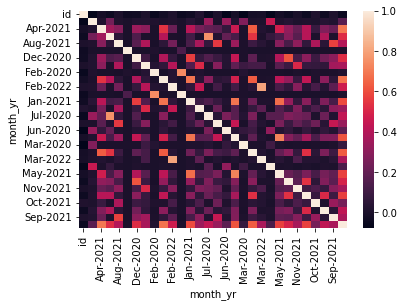

In [273]:
# Let’s visualize the correlation between variables

import seaborn as sns
sns.heatmap(transactions.corr())

Selecting Feature


Here, you need to divide the given columns into two types of variables dependent and independent variable. Select latest 24 month as independent variable.

In [274]:
# from the 28 months we need to choose how many will be used for the model.

data['month_yr'].unique() 

array(['Mar-2022', 'Feb-2022', 'Jan-2022', 'Dec-2021', 'Nov-2021',
       'Oct-2021', 'Sep-2021', 'Aug-2021', 'Jul-2021', 'Jun-2021',
       'May-2021', 'Apr-2021', 'Mar-2021', 'Feb-2021', 'Jan-2021',
       'Dec-2020', 'Nov-2020', 'Oct-2020', 'Sep-2020', 'Aug-2020',
       'Jul-2020', 'Jun-2020', 'May-2020', 'Apr-2020', 'Mar-2020',
       'Feb-2020', 'Jan-2020', 'Dec-2019'], dtype=object)

In [275]:
X= transactions[['Mar-2022', 'Feb-2022', 'Jan-2022', 'Dec-2021', 'Nov-2021',
       'Oct-2021', 'Sep-2021', 'Aug-2021', 'Jul-2021', 'Jun-2021',
       'May-2021', 'Apr-2021', 'Mar-2021', 'Feb-2021', 'Jan-2021',
                'Dec-2020', 'Nov-2020', 'Oct-2020', 'Sep-2020', 'Aug-2020']] # last 24 months
y= transactions[['CLV']]

In [276]:
#split training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 50)
# random state to take the same results in each run

In [277]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()


# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, Y_train)


# make predictions on the testing set
y_pred = linreg.predict(X_test)

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[1830.67219359]
[[1.01167162 0.93723775 0.97497648 1.1336007  1.06294371 1.01319259
  1.01574544 0.98163043 0.96380914 1.12757214 1.01784135 0.95770296
  0.92653398 1.02870423 0.99906747 0.99291917 1.13384741 0.84709734
  0.90280358 1.67551208]]


Here, we observe that the features have positive correlation with the target variable.

# Model Evaluation

In [278]:
import numpy as np 
from sklearn import metrics

print("R-Square:",metrics.r2_score(Y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

R-Square: 0.9474697852351229
Mean Absolute Error: 3609.1511798433885
Mean Squared Error: 369603071.69485277
Root Mean Squared Error: 19225.06363305081


In [279]:
linreg.score(X_test, Y_test) # model.score = R-square

0.9474697852351229

In [280]:
def flatten(xss):
    return [x for xs in xss for x in xs]

flat_y_pred = flatten(y_pred)

In [296]:
# prediction of clv for new (unseen) customers.

result = pd.DataFrame({'id':data.iloc[X_test.index]['id'].values,'CLV_pred':flat_y_pred})
result

,id,CLV_pred
0,108917,1921.360250
1,110492,76658.540016
2,112307,1853.349142
3,114731,2074.268242
4,113280,1875.812373
...,...,...
1994,118983,1830.672194
1995,111585,2228.714181
1996,112274,15679.512629
1997,110018,2012.849634


In [297]:
result['CLV_pred'].describe()

count    1.999000e+03
mean     1.492415e+04
std      7.690166e+04
min      1.830672e+03
25%      1.894634e+03
50%      2.086496e+03
75%      4.027137e+03
max      1.716213e+06
Name: CLV_pred, dtype: float64

# Results 

The results must be compared with the baseline method:
    CLV = (average_sales * average_frerq / churn) * profit_margin
we assume that the profit margin is 0.03

In [282]:
sum_amount = cust_data.groupby('id')['amount'].sum() # total amount per customer
transactions_count = cust_data.groupby('id').count()['settledAt']#total number of transactions per customer - frequency

In [283]:
evaluation_data = pd.merge(transactions_count,sum_amount,on='id') # make a dataframe to evaluate the results 

In [284]:
evaluation_data.columns = ['num_transactions','sum_amount']

In [285]:
evaluation_data['transaction_value'] = evaluation_data['sum_amount'] / evaluation_data['num_transactions']
evaluation_data['monthly_CLV'] = evaluation_data['sum_amount'] /28
evaluation_data

,num_transactions,sum_amount,transaction_value,monthly_CLV
id,,,,
5774,2,100.00,50.000000,3.571429
5825,3,46.00,15.333333,1.642857
5830,1,100.00,100.000000,3.571429
5838,23,1195.77,51.990000,42.706071
5839,30,916.68,30.556000,32.738571
...,...,...,...,...
128786,1,70.00,70.000000,2.500000
128797,1,100.00,100.000000,3.571429
128850,1,159.00,159.000000,5.678571


In [292]:
# Now, we  calculate the CLV for the Aggregate model.

# first, we calculate the necessary variables.
average_amount = round(np.mean(evaluation_data['sum_amount']),2)
average_frerq = round(np.mean(evaluation_data['num_transactions']),2)
retention_rate = evaluation_data[evaluation_data['num_transactions']>1].shape[0]/evaluation_data.shape[0]
churn = round(1-retention_rate,2)

print('average_amount = ',average_amount,'average_frerq = ',average_frerq,'retention_rate = ',
      retention_rate,'churn = ',churn)

average_amount =  18177.99 average_frerq =  18.98 retention_rate =  0.8707401291097433 churn =  0.13


In [298]:
profit_margin = 0.03 # assumption 

CLV = round(((average_amount*average_frerq)/churn)*profit_margin,2)

print('The CLV for each customer is :  ',CLV)

The CLV for each customer is :   79619.6


From our basic model, we got a CLV value of $80K for each customer. It is really high. The reason is because of the very high amount value from very few customers, which actually skewed the overall number. Indeed:

In [288]:
data['amount'].describe()

count    126394.000000
mean        957.985356
std        6195.192440
min           0.010000
25%          12.260000
50%          30.000000
75%         141.827500
max      550000.000000
Name: amount, dtype: float64